# Varying effects and LKJCorr

I'm convinced that partial pooling is a method that leads to better estimates. One approach of the varying effects strategy is to leverage co-variation between parameters.

Let's examine this and how LKJCorr fits in while understanding how `pymc` can be used.


References:
- McElreath chapter
- https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/LKJ.html
- SR pymc repo

In [162]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import itertools
from matplotlib.patches import Ellipse, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit
import scipy.linalg as linalg
import seaborn as sns
import statsmodels.api as sm

import igraph
import cairocffi
from theano import tensor as tt

<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [4]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

We'll use McElreath's example that opens Chapter 14 and run the model forwards before running it backwards which helps [to facilitate understanding](https://benslack19.github.io/data%20science/statistics/stats_rethinking_ch03_sim4blog_part1/).

The cafe example is:


$$C_i \sim \text{Binomial}(1, p_i) \tag{likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]}U_{[i]} \tag{linear model with link function}$$

Matrix of varying intercepts and slopes and its covariance matrix:


$$\begin{bmatrix}\alpha_{\text{cafe}} \\ \beta_{\text{cafe}} \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\alpha \\ \beta \end{bmatrix} , \textbf{S} \right)  \tag{population of varying effects} $$

In this prior, we have an intercept term for each district (average contraception use) and the slope (how much it changes if a woman lives in an urban district). Instead of having separate lines for the prior, we put them in the same multivariate normal covariance matrix to allow information sharing between slopes and priors. This allows adaptive regularization of individual district intercepts, their slopes, and the correlation among them. 

The covariance matrix **S** is defined here.

$$ \textbf{S} = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}  $$

Why is the covariance matrix set up with separate standard deviations and a correlation matrix? way? Per the text, "splitting the covaraince up into standard deviations and correlations... [will make it] easier to later understand the inferred structure of the varying effects."

We'll need a minimal set of starting values to create the simulation and we'll assemble a few more parts from it.

In [140]:
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes


<IPython.core.display.Javascript object>

To get the correlated structure, we will need a multivariate normal distribution. There are two parts, a vector of the averages for each of our parameters and a covariance matrix.

Here, we'll create a  vector which we'll call $\mu$ to hold our average slope and intercept. This is straightforward.

In [141]:
Mu = [a, b]

<IPython.core.display.Javascript object>

The covariance matrix is built a few different ways, but it'll help to understand all versions of it. I'll show three methods, with each increasing in weirdness.

The first method is most intuitive way for me.

$$ \bold{S} = \begin{pmatrix} \sigma_{\alpha}^2 & \rho\sigma_{\alpha}\sigma_{\beta} \\ \rho\sigma_{\alpha}\sigma_{\beta} & \sigma_{\beta}^2 \end{pmatrix} $$

The diagonals show each individual parameter's variance (standard deviation squared) while the off-diagonal shows the co-variance, represented as the correlation coefficient $\rho$ multiplied by each parameter standard deviation.

I'll use `Sigma1` with capital S to represent this covariance matrix with the `1` representing this first method of assembly but as you'll see, they will be equivalent. (In equations like above, the covariance matrix is represented by a bold, capital S.)

In [142]:
cov_ab = rho * sigma_a * sigma_b
Sigma1 = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
Sigma1

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

<IPython.core.display.Javascript object>

The second method for building the covariance matrix will be weirder:
- arrange the standard deviations along the diagonal and fill in zeros everywhere else
- matrix multiply by a *correlation* matrix
- matrix multiply by the same arrangement of standard deviations along the diagonal

Here's how it looks in equation form:

$$ \textbf{S} = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}  $$



To create a matrix where the standard deviations are on the diagonal and zeros are everywhere, we can use a handy `numpy` function called diag:

In [147]:
# put the sigmas in a vector first
sigmas = [sigma_a, sigma_b]

# represent on the diagonal
sigma_diag = np.diag(sigmas)
sigma_diag

array([[1. , 0. ],
       [0. , 0.5]])

<IPython.core.display.Javascript object>

The $\bold{R}$ matrix is where `rho` is arranged in the off-diagonals, where `rho` represents the correlation between the two parameters. The diagonals show values of 1 since each parameter will always be perfectly correlated with itself.

In [145]:
Rmat = np.array([[1, rho], [rho, 1]])
Rmat

array([[ 1. , -0.7],
       [-0.7,  1. ]])

<IPython.core.display.Javascript object>

Now the final step is the matrix multiplication. In `numpy`, I learned how to do a small chain of matrix multiplication from [this SO post](https://stackoverflow.com/questions/11838352/multiply-several-matrices-in-numpy).

In [154]:
Sigma2 = sigma_diag.dot(Rmat).dot(sigma_diag)
Sigma2

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

<IPython.core.display.Javascript object>

As expected, we get the same values of the covariance matrix as we did with the previous method.

As promised, this third method gets even more weird. It deserves its own expansive exploration but I'll just show how it works now then explain later. The first thing we need to do is get the Cholesky factor which can be derived from the $\bold{R}$ correlation matrix.

In [168]:
# scipy.linalg.cholesky does the upper triangle
# linalg.cholesky(Rmat)

# numpy.linalg.cholesky does the lower triangle
L = np.linalg.cholesky(Rmat)
L

array([[ 1.        ,  0.        ],
       [-0.7       ,  0.71414284]])

<IPython.core.display.Javascript object>

The matrix $\bold{R}$ can be derived from this Cholesky factor with the following equation:

$ \bold{R} = \bold{LL}^\intercal $

Accordingly, we can substitute for $\bold{R}$ in the equation we saw above:

$$ \textbf{S} = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \bold{LL}^\intercal  \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}  $$

In code, we can get this third re-construction of $\bold{S}$ like this:

In [172]:
Sigma3 = sigma_diag.dot(L).dot(L.T).dot(sigma_diag)
Sigma3

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

<IPython.core.display.Javascript object>

As we would expect, the two ways to get the covariance matrix give equivalent results.

I'll show why using this second method, where correlation coefficients are stored in a separate matrix, will be more useful.

## LKJcorr

Rather than continue with the simulation, I'd like to digress here and jump to talking about the LKJ distribution. There's already explanations out there that can help such as the following:

- [Original paper](https://www.sciencedirect.com/science/article/pii/S0047259X09000876?via%3Dihub)
- https://distribution-explorer.github.io/multivariate_continuous/lkj.html
- https://yingqijing.medium.com/lkj-correlation-distribution-in-stan-29927b69e9be
- https://stats.stackexchange.com/questions/304684/why-lkjcorr-is-a-good-prior-for-correlation-matrix

However, I felt those references were more useful after I got my hands dirty. I learned by continuing to try some of McElreath's problems and dissecting some of the `pymc` output.

Let's just take 5 draws from an LKJ distribution with eta of 2.

In [179]:
# rho values for 2x2 covariance matrix (smallest you can do)
pm.LKJCorr.dist(n=2, eta=2).random(size=1)

array([[-0.22832633]])

<IPython.core.display.Javascript object>

For each draw, where does the one unique value from each draw come from? Since the covariance matrix is 2x2, and the diagonal is 1, we only need one rho value to complete the matrix since the off-diagonals are symmetric like this:

```
[1  a]
[a  1]
```

Why do we even the LKJ distribution? If we need a prior distribution for rho, can't we use a beta distribution? After all, we only need one value since the off-diagonals are symmetric. We can see quickly that the 2x2 co-variance matrix is a special case. We immediately appreciate that once we use a 3x3 matrix?

In [180]:
# 5 draws of rho values for 3x3 covariance matrix
pm.LKJCorr.dist(n=3, eta=2).random(size=5)

array([[ 0.15983109,  0.52877699, -0.28766951],
       [-0.49810272, -0.57094286,  0.17752743],
       [-0.04335005, -0.41742017, -0.1595826 ],
       [ 0.29467962,  0.78797917,  0.06524737],
       [ 0.39842705,  0.2483732 , -0.21230187]])

<IPython.core.display.Javascript object>

Where do the three unique values from each draw come from? Again, the diagonal is 1, while the off-diagonals are symmetric. We now have `a`, `b`, and `c` to represent rho values between the first and second parameters, first and third parameters, and second and third paramters, respectively.
```
[1  a  b]
[a  1  c]
[b  c  1]
```

We see this same pattern continue when we increase the dimensions of the covariance matrix by one yet again.

In [181]:
# 5 draws of rho values for 4x4 covariance matrix
pm.LKJCorr.dist(n=4, eta=2).random(size=5)

array([[-0.02994338,  0.53984205, -0.47865583,  0.41198976,  0.23896715,
         0.18721871],
       [-0.16844814, -0.78174385, -0.11759887,  0.669429  ,  0.36519004,
         0.37638264],
       [ 0.22656789,  0.36737136,  0.50664715, -0.11265764,  0.34904555,
         0.12510309],
       [-0.74953237, -0.20362676,  0.52276053,  0.47983261, -0.65953212,
        -0.11663596],
       [ 0.53445779,  0.63483434,  0.03094951,  0.54065298,  0.53795557,
         0.11956918]])

<IPython.core.display.Javascript object>

Where do the six unique values from each draw come from? The unique values are shown in this arrangement. Again, the diagonal is 1, while the off-diagonals are symmetric.
```
[1  a  b  c]
[a  1  d  e]
[b  d  1  f]
[c  e  f  1]
```

Remember that we don't have the covariance matrix yet. We only have sampled *correlation* matrices. But we can get the covariance matrix once we take some sampled sigmas.

Let's do that to see how this would look in 5 draws from a prior distribution. We wouldn't do this for an actual problem. This is just to demonstrate what sampling would look like, step-by-step. We'll go back to a 2x2 covariance matrix to make things simple.

In [182]:
for i in range(5):
    # only one rho value since this is a 2x2 corelation matrix
    # the [0] is just to get the value out of the array
    rho = pm.LKJCorr.dist(n=2, eta=2).random(size=1)[0][0]
    Rmat = np.array([[1, rho], [rho, 1]])
    # the sigmas themselves need to be sampled; again the [0] is to get the value out of the array
    sigma_a = pm.Exponential.dist(1.0).random(size=1)[0]
    sigma_b = pm.Exponential.dist(1.0).random(size=1)[0]
    sigmas = np.array([sigma_a, sigma_b])
    Sigma = np.diag(sigmas).dot(Rmat).dot(np.diag(sigmas))
    print(f"sample {i}\n -- sigma for a: {sigma_a}\n -- sigma for b: {sigma_b}\n -- Rho: {rho}, \n -- covariance matrix:\n{Sigma}\n")

sample 0
 -- sigma for a: 8.439924903071201
 -- sigma for b: 0.592797205783266
 -- Rho: -0.3927248120317488, 
 -- covariance matrix:
[[71.23233237 -1.9648666 ]
 [-1.9648666   0.35140853]]

sample 1
 -- sigma for a: 0.24734450067965127
 -- sigma for b: 0.0854281989368306
 -- Rho: -0.5600074363585177, 
 -- covariance matrix:
[[ 0.0611793  -0.01183307]
 [-0.01183307  0.00729798]]

sample 2
 -- sigma for a: 0.2031823220834629
 -- sigma for b: 1.2317293258116313
 -- Rho: 0.2995374368209365, 
 -- covariance matrix:
[[0.04128306 0.07496392]
 [0.07496392 1.51715713]]

sample 3
 -- sigma for a: 0.23625879085112234
 -- sigma for b: 0.2833592363699089
 -- Rho: -0.16417147497065487, 
 -- covariance matrix:
[[ 0.05581822 -0.01099064]
 [-0.01099064  0.08029246]]

sample 4
 -- sigma for a: 1.9227040371169182
 -- sigma for b: 0.7004390728538227
 -- Rho: -0.5775963454312567, 
 -- covariance matrix:
[[ 3.69679081 -0.77787039]
 [-0.77787039  0.49061489]]



<IPython.core.display.Javascript object>

## Cholesky decomposition

We encounter Cholesky factors later in chapter 14 when doing non-centered paramaterizations. It's helpful to look at this now that we've broken down covariance matrices and the LKJ distribution.

Example of cholesky decomposition [post](https://atozmath.com/example/CONM/GaussEli.aspx?he=e&q=CD2#:~:text=1.,225y%2B979z%3D1259&text=Cholesky%20decomposition%20%3A%20A%3DL%E2%8B%85,matrix%20L%20and%20its%20transpose.)

Let's take a sample of rho values for a 3x3 correlation matrix using an LKJ distribution with eta value of 2. The values don't matter. We're just looking to have an example.

In [183]:
ax, bx, cx = pm.LKJCorr.dist(eta=2, n=3).random(size=1)[0]
ax, bx, cx

(-0.6852479804482652, -0.7411611547301553, 0.8954648820382417)

<IPython.core.display.Javascript object>

In [184]:
# 3x3 Rmatrix
# matrix of Rhos (correlation coefficients)
Rmat = np.array([[1, ax, bx], [ax, 1, cx], [bx, cx, 1]])
Rmat


array([[ 1.        , -0.68524798, -0.74116115],
       [-0.68524798,  1.        ,  0.89546488],
       [-0.74116115,  0.89546488,  1.        ]])

<IPython.core.display.Javascript object>

The definition of a Cholesky decomposition is:

$ \bold{R} = \bold{L}\bold{L}^\intercal $

Therefore, you're taking a matrix and doing a matrix multiplication on its transpose. It seemed like a deceivingly simple equation and when I was first reading about this, I **thought** the $\bold{L}$ was simply the lower triangle of the correlation matrix. It is **not** as you will see below.

In [185]:
np.tril(Rmat)

array([[ 1.        ,  0.        ,  0.        ],
       [-0.68524798,  1.        ,  0.        ],
       [-0.74116115,  0.89546488,  1.        ]])

<IPython.core.display.Javascript object>

However, carrying out the above equation does not give only 1 on the diagonal and some of the off-diagonals are incorrect even though they're numerically close in value.

In [186]:
# WRONG - this is not a correlation matrix
np.tril(Rmat).dot(np.tril(Rmat).T)

array([[ 1.        , -0.68524798, -0.74116115],
       [-0.68524798,  1.46956479,  1.40334407],
       [-0.74116115,  1.40334407,  2.35117721]])

<IPython.core.display.Javascript object>

I hadn't realized that there was a `numpy` function to get the Cholesky factor already. Again, there's close numerical similarity to the lower triangle.

In [187]:
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html
np.linalg.cholesky(Rmat)

array([[ 1.        ,  0.        ,  0.        ],
       [-0.68524798,  0.72830983,  0.        ],
       [-0.74116115,  0.53217145,  0.40923549]])

<IPython.core.display.Javascript object>

This is the way to get the correlation matrix back to what we want.

In [188]:
# RIGHT way to get a correlation matrix
np.linalg.cholesky(Rmat).dot(np.linalg.cholesky(Rmat).T)

array([[ 1.        , -0.68524798, -0.74116115],
       [-0.68524798,  1.        ,  0.89546488],
       [-0.74116115,  0.89546488,  1.        ]])

<IPython.core.display.Javascript object>

I'm not going to work out the math as has been done [here] but this exercise gave me some intuition for what the Cholesky factors are doing.

OK, we went on this sidebar to better understand the Cholesky decomposition but ultimately we're looking to get an alternate paramterization of our priors.

Let's remind ourselves what distribution we're trying to get.

$$\begin{bmatrix}\alpha_{\text{cafe}} \\ \beta_{\text{cafe}} \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\alpha \\ \beta \end{bmatrix} , \textbf{S} \right)  \tag{population of varying effects} $$

In [72]:
# 3 different sigmas, all sampled at once
sigmas = pm.Exponential.dist(1.0).random(size=3)
sigmas

array([2.21705683, 0.59783377, 1.4090169 ])

<IPython.core.display.Javascript object>

In [120]:
# centered way to get covariance matrix
np.diag(sigmas).dot(Rmat).dot(np.diag(sigmas))

array([[ 4.915341  ,  0.12859791, -0.82687312],
       [ 0.12859791,  0.35740522, -0.70176151],
       [-0.82687312, -0.70176151,  1.98532864]])

<IPython.core.display.Javascript object>

In [122]:
# non-centered way to get covariance matrix

L = np.linalg.cholesky(Rmat)

np.diag(sigmas).dot(L.dot(L.T)).dot(np.diag(sigmas))

array([[ 4.915341  ,  0.12859791, -0.82687312],
       [ 0.12859791,  0.35740522, -0.70176151],
       [-0.82687312, -0.70176151,  1.98532864]])

<IPython.core.display.Javascript object>

array([ 0.24331156,  0.34824728, -0.31361309])

<IPython.core.display.Javascript object>

In [88]:
# gets cholesky factor but not exact?
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html
np.linalg.cholesky(Rmat).dot(np.linalg.cholesky(Rmat).T)

array([[1.        , 0.43833912, 0.16633477],
       [0.43833912, 1.        , 0.22417881],
       [0.16633477, 0.22417881, 1.        ]])

<IPython.core.display.Javascript object>

In [89]:
np.linalg.cholesky(Rmat)

array([[1.        , 0.        , 0.        ],
       [0.43833912, 0.89880967, 0.        ],
       [0.16633477, 0.1682979 , 0.97160103]])

<IPython.core.display.Javascript object>

In [90]:
np.tril(Rmat)

array([[1.        , 0.        , 0.        ],
       [0.43833912, 1.        , 0.        ],
       [0.16633477, 0.22417881, 1.        ]])

<IPython.core.display.Javascript object>

In [91]:
np.tril([[1, 0.2], [0.2, 1]])

array([[1. , 0. ],
       [0.2, 1. ]])

<IPython.core.display.Javascript object>

In [92]:
np.linalg.cholesky([[1, 0.2], [0.2, 1]])

array([[1.       , 0.       ],
       [0.2      , 0.9797959]])

<IPython.core.display.Javascript object>

In [74]:
# with cholesky factor


# L = 

np.linalg.cholesky(np.diag(sigmas).dot(Rmat).dot(np.diag(sigmas)))

array([[2.21705683, 0.        , 0.        ],
       [0.26205393, 0.53733877, 0.        ],
       [0.2343685 , 0.23713458, 1.36900228]])

<IPython.core.display.Javascript object>

We need a posterior distribution surface - analogy with univariate normal.

Parameter that depends on another parameter

Make this a table

left has univariate, right has multivariate ... first is centered, second is non-centered

$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) $$ 
$$ \bar{\alpha} \sim \text{Normal}(0, 1.5) $$
$$ \sigma \sim \text{Exponential}(1) $$

We're moving the stochasticity somewhere else and putting a deterministic relationship at the end.

$$ \alpha_j = \bar{\alpha} + z \times \sigma_{\alpha} $$ 
$$ \bar{\alpha} \sim \text{Normal}(0, 1.5) $$
$$ z \sim \text{Normal}(0, 1) $$
$$ \sigma \sim \text{Exponential}(1) $$

$$\begin{bmatrix}\alpha_{\text{cafe}} \\ \beta_{\text{cafe}} \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\alpha \\ \beta \end{bmatrix}, \textbf{R}, \text{sigmas} \right)  \tag{population of varying effects} $$

You'd typically center over 0.

$$ \begin{bmatrix}\alpha_{\text{cafe}} \\ \beta_{\text{cafe}} \end{bmatrix} = \begin{bmatrix}\bar{\alpha}_{\text{cafe}}  \\ \bar{\beta}_{\text{cafe}} \end{bmatrix} + (\text{diag}(\bold{S})\bold{L}\bold{Z})^\intercal $$



```
# define 2D Gaussian with correlation 0.6
N <- 1e4
sigma1 <- 2
sigma2 <- 0.5
rho <- 0.6
# independent z-scores
z1 <- rnorm( N )
z2 <- rnorm( N )
# use Cholesky to blend in correlation
a1 <- z1 * sigma1
a2 <- ( rho*z1 + sqrt( 1-rho^2 )*z2 )*sigma2
````

In [189]:
sigmas

array([1.92270404, 0.70043907])

<IPython.core.display.Javascript object>

In [200]:
N = 10**4


# Z needs to have the same number of parameters to be correlated
z1 = stats.norm.rvs(0, 1, size=N)
z2 = stats.norm.rvs(0, 1, size=N)
Z = np.array([z1, z2])

a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

sigmas = np.array([sigma_a, sigma_b])



<IPython.core.display.Javascript object>

In [194]:
L = np.linalg.cholesky(np.matrix([[1, rho], [rho, 1]]))
L

matrix([[ 1.        ,  0.        ],
        [-0.7       ,  0.71414284]])

<IPython.core.display.Javascript object>

In [195]:
sigmas_diag = np.diag(sigmas)
sigmas_diag

array([[1. , 0. ],
       [0. , 0.5]])

<IPython.core.display.Javascript object>

`ab` is deterministic
ab

In [210]:
ab = sigmas_diag.dot(L).dot(Z).T
ab

matrix([[-0.94693737,  0.53973389],
        [-0.07641949,  0.29486172],
        [-0.35485409, -0.53640981],
        ...,
        [-0.43663961, -0.1795311 ],
        [-0.4608157 ,  0.09497951],
        [-0.18532586, -0.17574696]])

<IPython.core.display.Javascript object>

In [209]:
# recover standard deviations
np.std(ab[:, 0]), np.std(ab[:, 1])

(1.0015337680532155, 0.5017557426963157)

<IPython.core.display.Javascript object>

In [218]:
# recover correlation between intercepts and slopes
np.corrcoef(ab.T)

array([[ 1.        , -0.69687613],
       [-0.69687613,  1.        ]])

<IPython.core.display.Javascript object>

In [220]:
aj = a + ab[:, 0]
np.mean(aj), np.std(aj)

(3.5223414992944977, 1.0015337680532155)

<IPython.core.display.Javascript object>

In [221]:
bj = b + ab[:, 1]
np.mean(bj), np.std(bj)

(-1.0027543005748294, 0.5017557426963157)

<IPython.core.display.Javascript object>

$$\begin{bmatrix}\alpha_{\text{cafe}} \\ \beta_{\text{cafe}} \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\alpha \\ \beta \end{bmatrix} , \textbf{S} \right)  \tag{population of varying effects} $$

# Back to the simulation

In [132]:
Sigma2

array([[0.4137943 , 0.04225449],
       [0.04225449, 2.07495124]])

<IPython.core.display.Javascript object>

In [133]:
N_cafes = 20
vary_effects = stats.multivariate_normal.rvs(mean=Mu, cov=Sigma2, size=N_cafes)
vary_effects

array([[ 2.40491092, -2.33086196],
       [ 2.9426791 , -2.81889902],
       [ 2.47983117, -1.46842757],
       [ 3.65138682, -3.38162253],
       [ 2.87044653, -1.42216932],
       [ 4.81303729, -1.13117912],
       [ 3.71164751,  0.19179536],
       [ 2.75993647, -2.8014631 ],
       [ 3.49571285,  1.0249935 ],
       [ 2.8786612 ,  0.82633752],
       [ 2.95845457, -1.15358518],
       [ 2.52652133, -0.58632796],
       [ 3.13683212, -1.59567287],
       [ 3.74516879, -1.07651027],
       [ 3.89509228,  0.41309478],
       [ 4.54195153, -0.53181201],
       [ 2.66434663, -0.93930539],
       [ 3.0008423 , -1.66744065],
       [ 3.94551585, -3.51399612],
       [ 3.41955548, -2.38465359]])

<IPython.core.display.Javascript object>

In [134]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'a'),
 Text(0, 0.5, 'b'),
 Text(0.5, 1.0, 'varying effects\n(samples from MV Gaussian)')]

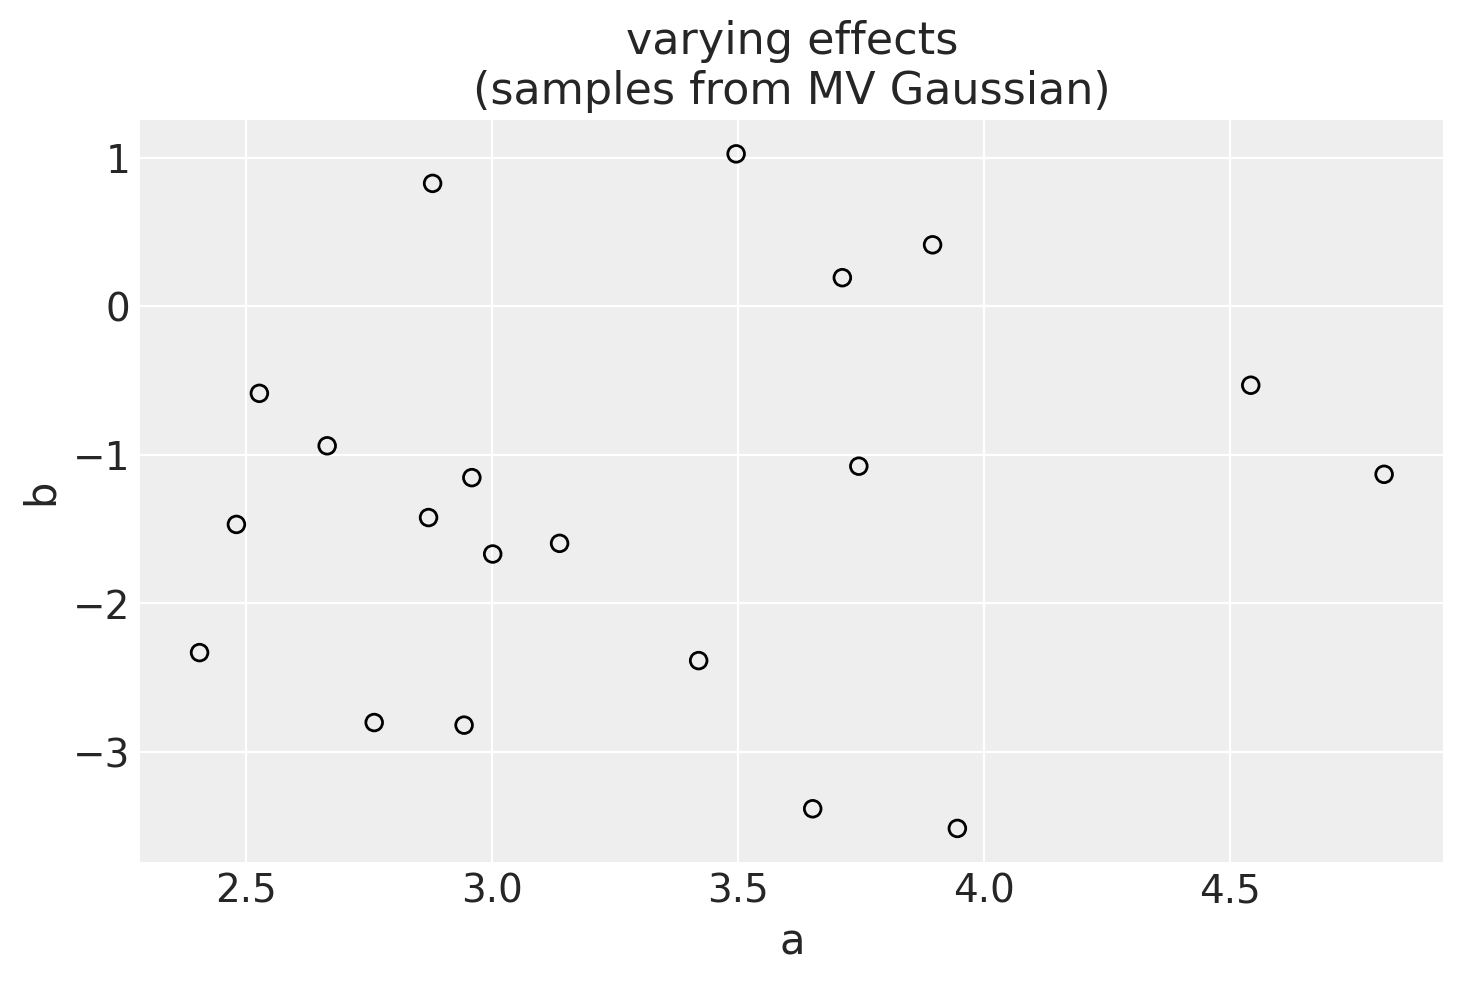

<IPython.core.display.Javascript object>

In [135]:
f, ax0 = plt.subplots()
ax0.scatter(a_cafe, b_cafe, facecolors='none', edgecolors='black')
ax0.set(xlabel='a', ylabel='b', title='varying effects\n(samples from MV Gaussian)')

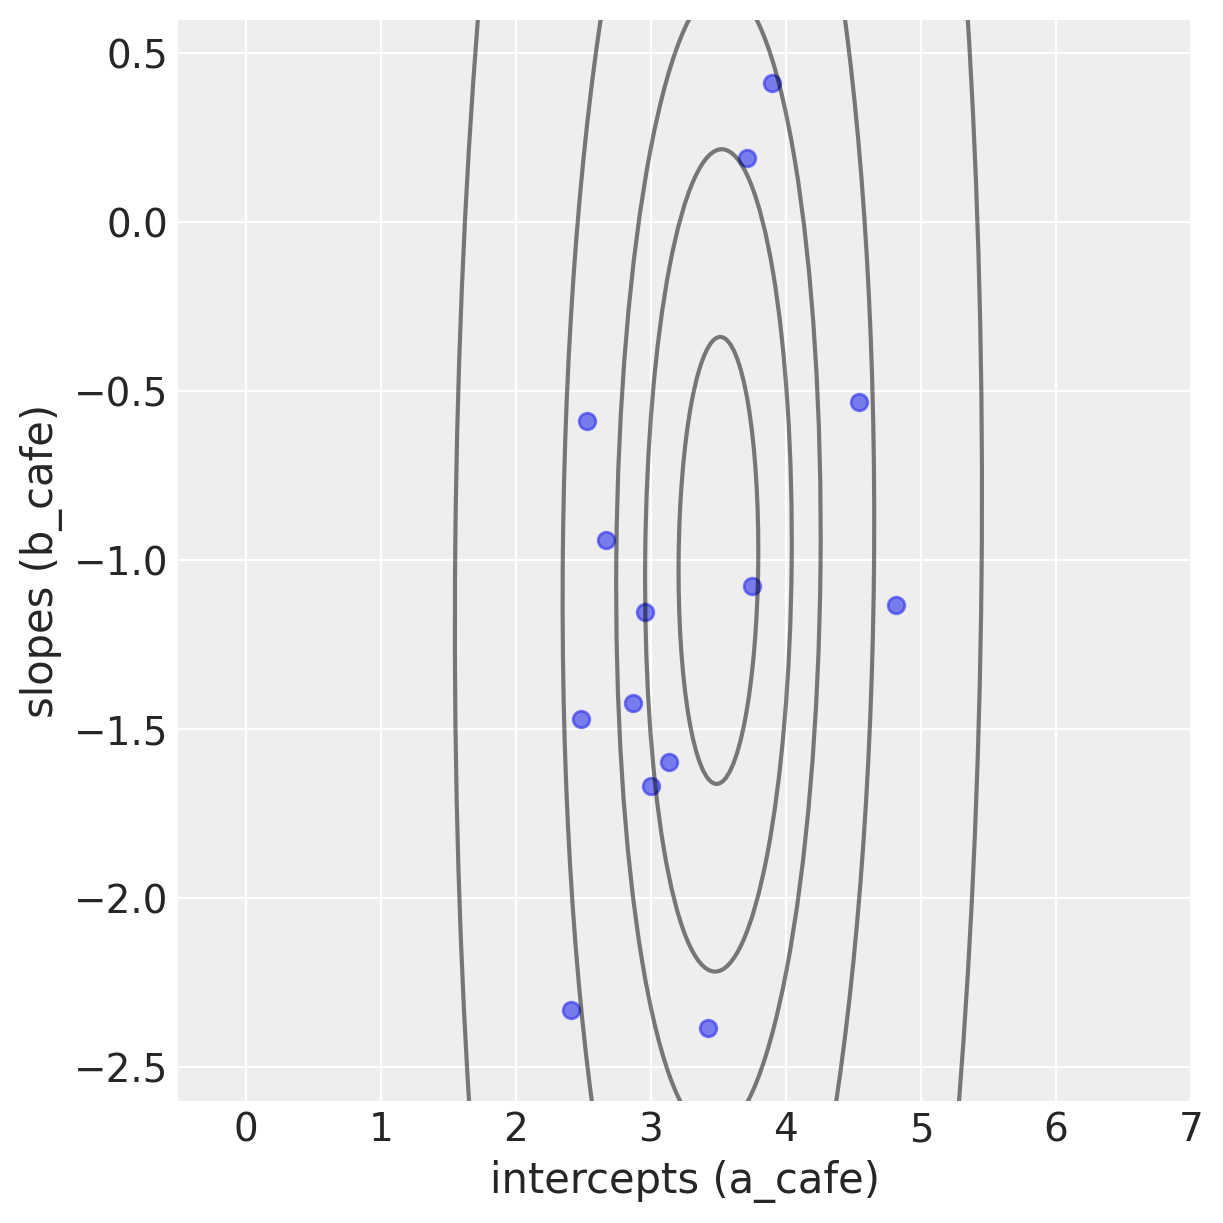

<IPython.core.display.Javascript object>

In [136]:
# repo code
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * stats.chi2.ppf(level, 2))  # get size corresponding to level
        ell = Ellipse(
            mu[:2],
            v[0],
            v[1],
            180 + angle,
            facecolor="None",
            edgecolor="k",
            alpha=(1 - level) * 0.5,
            lw=1.5,
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    return ax

ax = Gauss2d(Mu, np.asarray(Sigma), [0.1, 0.3, 0.5, 0.8, 0.99])
ax.scatter(a_cafe, b_cafe, alpha=0.6)
ax.set_xlim(-0.5, 7)
ax.set_ylim(-2.6, 0.6)
ax.set_xlabel("intercepts (a_cafe)")
ax.set_ylabel("slopes (b_cafe)");

In [53]:
# simulating observations

N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
d


,cafe,afternoon,wait
0,0,0,4.419218
1,0,1,4.044468
2,0,0,4.910498
3,0,1,3.805948
4,0,0,3.194937
...,...,...,...
195,19,1,2.781553
196,19,0,2.920572
197,19,1,1.767696
198,19,0,3.387296


<IPython.core.display.Javascript object>

## Cafe model

In [42]:
# rho values for 2x2 covariance matrix (smallest you can do)
pm.LKJCorr.dist(n=2, eta=2).random(size=5)

array([[ 0.41850245],
       [-0.26480722],
       [ 0.26319114],
       [-0.73448809],
       [-0.25071827]])

<IPython.core.display.Javascript object>

Where does the one unique value from each draw come from? The diagonal is 1, while the off-diagonals are symmetric.

```
[1  a]
[a  1]
```

In [43]:
# 5 draws of rho values for 3x3 covariance matrix
pm.LKJCorr.dist(n=3, eta=2).random(size=5)

array([[ 0.39977712, -0.28989647, -0.12767101],
       [ 0.11297639,  0.16458504, -0.42417532],
       [ 0.30339437,  0.09790431,  0.0839041 ],
       [ 0.63060815,  0.21274695,  0.29531789],
       [-0.13467037,  0.28636382, -0.33153925]])

<IPython.core.display.Javascript object>

Where do the three unique values from each draw come from? The diagonal is 1, while the off-diagonals are symmetric.
```
[1  a  b]
[a  1  c]
[b  c  1]
```

Example of cholesky decomposition [post](https://atozmath.com/example/CONM/GaussEli.aspx?he=e&q=CD2#:~:text=1.,225y%2B979z%3D1259&text=Cholesky%20decomposition%20%3A%20A%3DL%E2%8B%85,matrix%20L%20and%20its%20transpose.)

In [54]:
ax, bx, cx = pm.LKJCorr.dist(eta=2, n=3).random(size=1)[0]
ax, bx, cx

(0.11836011633697918, -0.27310877623550656, 0.09303384205027013)

<IPython.core.display.Javascript object>

In [22]:
# 3x3 Rmatrix
# matrix of Rhos (correlation coefficients)
Rmat = np.array([[1, ax, bx], [ax, 1, cx], [bx, cx, 1]])
Rmat


array([[ 1.        ,  0.47095259,  0.11311948],
       [ 0.47095259,  1.        , -0.3790755 ],
       [ 0.11311948, -0.3790755 ,  1.        ]])

<IPython.core.display.Javascript object>

In [27]:
(np.tril(Rmat) * np.tril(Rmat).T)

array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [ 0., -0.,  1.]])

<IPython.core.display.Javascript object>

In [35]:
# vector of standard deviations
sigmas = stats.expon.rvs(1, size=3)

<IPython.core.display.Javascript object>

In [36]:
# bottom of page 441
np.diag(sigmas)

array([[1.44987804, 0.        , 0.        ],
       [0.        , 1.3845631 , 0.        ],
       [0.        , 0.        , 1.69949849]])

<IPython.core.display.Javascript object>

In [38]:
# covariance matrix
np.dot(np.diag(sigmas), np.dot(Rmat, np.diag(sigmas)))

array([[ 2.10214633,  0.94541266,  0.27873381],
       [ 0.94541266,  1.91701498, -0.89198849],
       [ 0.27873381, -0.89198849,  2.88829513]])

<IPython.core.display.Javascript object>

In [32]:
stats.expon.rvs(1, size=3)

array([3.30553446, 2.07249073, 1.97262965])

<IPython.core.display.Javascript object>

In [26]:
np.tril(Rmat)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.47095259,  1.        ,  0.        ],
       [ 0.11311948, -0.3790755 ,  1.        ]])

<IPython.core.display.Javascript object>

In [25]:
np.tril(Rmat).T

array([[ 1.        ,  0.47095259,  0.11311948],
       [ 0.        ,  1.        , -0.3790755 ],
       [ 0.        ,  0.        ,  1.        ]])

<IPython.core.display.Javascript object>

Can I run the model in reverse and recover the parameters?

Blog post - understanding binomial non-centered parameterization to cholesky

In [44]:
# 5 draws of rho values for 4x4 covariance matrix
pm.LKJCorr.dist(n=4, eta=2).random(size=5)

array([[-0.48722943, -0.11877992, -0.09226821,  0.16099519, -0.10953461,
        -0.16289311],
       [-0.03688666, -0.39579662, -0.54428554,  0.42601435,  0.22259753,
         0.48262832],
       [-0.14576716, -0.12772004,  0.55233718, -0.79879026,  0.05077692,
        -0.38206162],
       [-0.80971911,  0.37136914,  0.54375009,  0.00211419, -0.57520381,
        -0.0387482 ],
       [ 0.03685408,  0.01085192, -0.44455902, -0.07588314,  0.14851583,
         0.32895511]])

<IPython.core.display.Javascript object>

Where do the six unique values from each draw come from? The diagonal is 1, while the off-diagonals are symmetric.
```
[1  a  b  c]
[a  1  d  e]
[b  d  1  f]
[c  e  f  1]
```

You really only need the upper or lower triangle to get the values for each combination.

In [45]:
for rho_i in pm.LKJCorr.dist(n=2, eta=2).random(size=5):
    print(np.diag(rho_i))

[[0.35260483]]
[[-0.57760929]]
[[-0.93377354]]
[[0.34006025]]
[[0.33628355]]


<IPython.core.display.Javascript object>

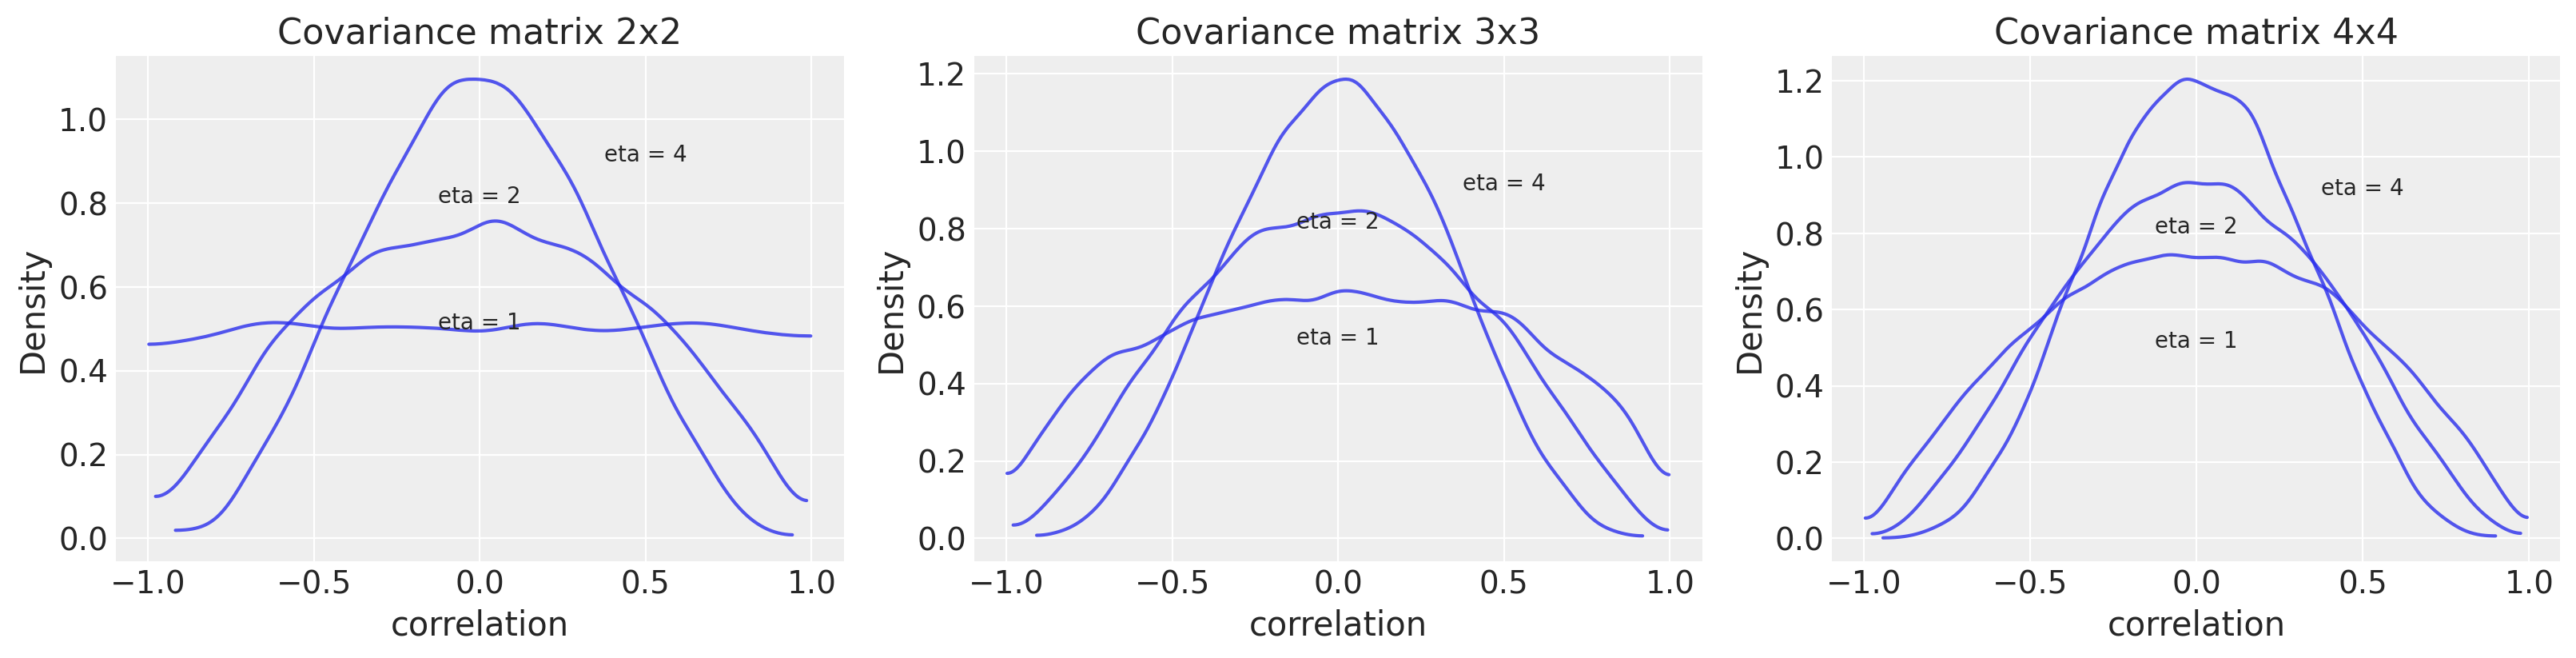

<IPython.core.display.Javascript object>

In [46]:
# repo code (for covariance matrix of 2x2)
f, ax = plt.subplots(1, 3, figsize=(16, 4))
textloc = [[0, 0.5], [0, 0.8], [0.5, 0.9]]

for i in range(3):
    for eta, loc in zip([1, 2, 4], textloc):
        R = pm.LKJCorr.dist(n=i+2, eta=eta).random(size=10000)
        az.plot_kde(R, plot_kwargs={"alpha": 0.8}, ax=ax[i])
        ax[i].text(loc[0], loc[1], "eta = %s" % (eta), horizontalalignment="center")

    ax[i].set_xlabel("correlation")
    ax[i].set_ylabel("Density")
    ax[i].set_title(f"Covariance matrix {i+2}x{i+2}");

In [47]:
R.shape

(10000, 6)

<IPython.core.display.Javascript object>

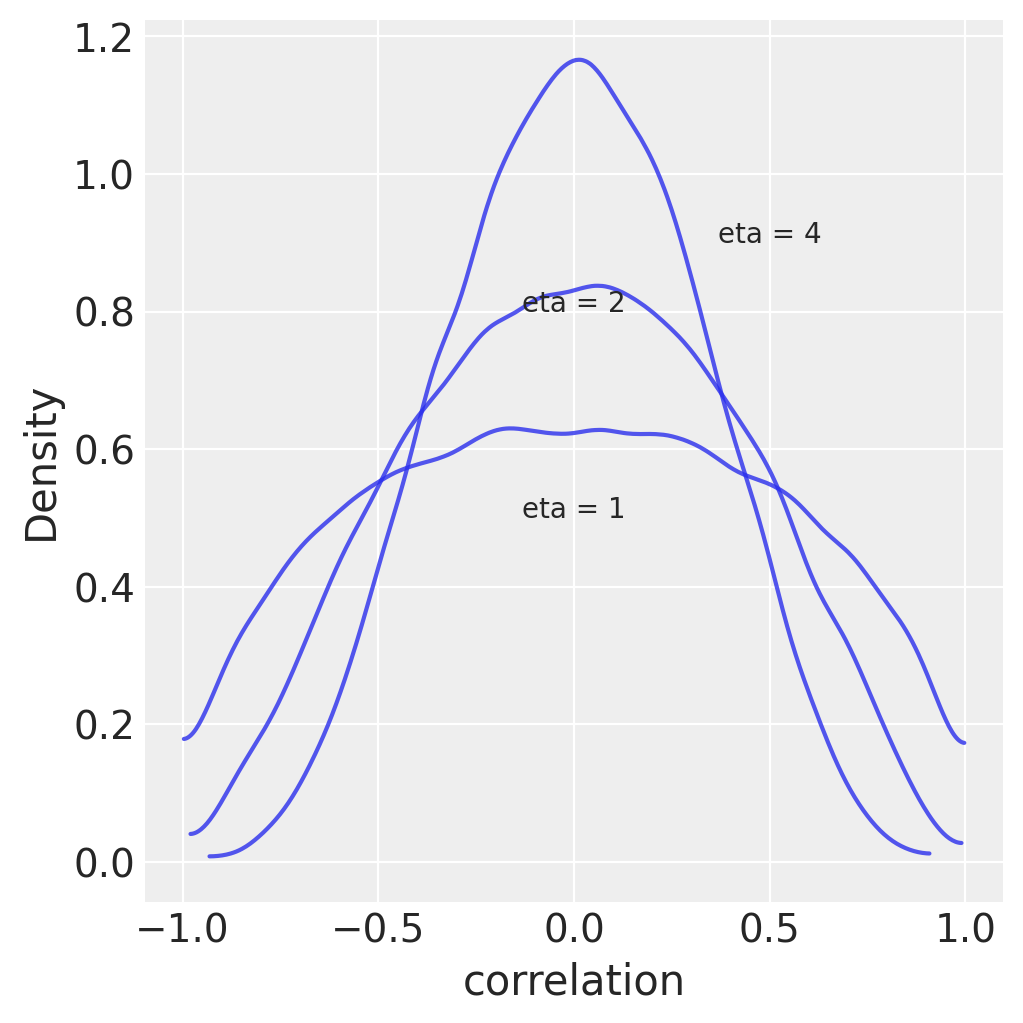

<IPython.core.display.Javascript object>

In [48]:
# repo code (for covariance matrix of 2x2)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
textloc = [[0, 0.5], [0, 0.8], [0.5, 0.9]]

for eta, loc in zip([1, 2, 4], textloc):
    R = pm.LKJCorr.dist(n=3, eta=eta).random(size=10000)
    az.plot_kde(R, plot_kwargs={"alpha": 0.8})
    ax.text(loc[0], loc[1], "eta = %s" % (eta), horizontalalignment="center")

ax.set_xlabel("correlation")
ax.set_ylabel("Density");

`pm.LKJCorr` only returns sampled rho values. I think `LKJCholeskyCov` would return the covariance matrix?

Why are there three values for chol_cov?

1. cholesky factor
2. Rho
3. sigma

Per pymc documentation for SR: `pm.LKJCholeskyCov` "extracts the stds and matrix of correlations automatically for us"

In [349]:
# not sure why pm.LKJCholeskyCov.dist isn't working

sd_dist = pm.Exponential.dist(1.0)
#chol, Rho, sigma = 

# pm.LKJCholeskyCov.dist(
#         n=2, eta=2, sd_dist=sd_dist, compute_corr=True
#     ).random(size=1)


# pm.LKJCholeskyCov.dist(
# n=2, eta=2).random(size=1)

<IPython.core.display.Javascript object>

In [350]:
d

,cafe,afternoon,wait
0,0,0,3.252189
1,0,1,1.468280
2,0,0,3.634038
3,0,1,2.496789
4,0,0,4.314220
...,...,...,...
195,19,1,2.593629
196,19,0,4.571482
197,19,1,1.829845
198,19,0,3.294634


<IPython.core.display.Javascript object>

In [55]:
# repo code

cafe_idx = d["cafe"].values
with pm.Model() as m14_1:
    # LKJCholeskyCov is more efficient than LKJCorr
    # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    a = pm.Normal("a", mu=5.0, sd=2.0)  # prior for average intercept
    b = pm.Normal("b", mu=-1.0, sd=0.5)  # prior for average slope
    ab_cafe = pm.MvNormal(
        "ab_cafe", mu=tt.stack([a, b]), chol=chol, shape=(N_cafes, 2)
    )  # population of varying effects
    # shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe

    mu = ab_cafe[cafe_idx, 0] + ab_cafe[cafe_idx, 1] * d["afternoon"].values  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within cafes

    wait = pm.Normal("wait", mu=mu, sigma=sigma_within, observed=d["wait"].values)  # likelihood

    trace_14_1 = pm.sample(1000, tune=4000, target_accept=0.9)



/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_within, ab_cafe, b, a, chol_cov]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 144 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [57]:
# check out the posterior for rho
az.summary(trace_14_1, var_names = 'chol_cov_corr')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"chol_cov_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"chol_cov_corr[0,1]",-0.546,0.224,-0.877,-0.223,0.004,0.003,2681.0,2681.0,2686.0,2816.0,1.0
"chol_cov_corr[1,0]",-0.546,0.224,-0.877,-0.223,0.004,0.003,2681.0,2681.0,2686.0,2816.0,1.0
"chol_cov_corr[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,3922.0,3864.0,1.0


<IPython.core.display.Javascript object>

In [58]:

# See renaming here to see what each variable refers to
idata_14_1 = az.from_pymc3(
        trace_14_1,
        dims={"ab_cafe": ["cafe_nbr", "var_effect"]},
        coords={
            "chol_cov_stds_dim_0": ["intercepts", "slopes"],
            "var_effect": ["intercepts", "slopes"],
        },
    )
post = idata_14_1.posterior = idata_14_1.posterior.rename_vars(
    {"chol_cov_corr": "Rho", "chol_cov_stds": "sigma_cafe"}
)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<IPython.core.display.Javascript object>

In [59]:
az.summary(idata_14_1, var_names='Rho')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"Rho[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Rho[0,1]",-0.546,0.224,-0.877,-0.223,0.004,0.003,2681.0,2681.0,2686.0,2816.0,1.0
"Rho[1,0]",-0.546,0.224,-0.877,-0.223,0.004,0.003,2681.0,2681.0,2686.0,2816.0,1.0
"Rho[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,3922.0,3864.0,1.0


<IPython.core.display.Javascript object>

In [60]:
az.summary(idata_14_1, var_names='sigma_cafe')

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_cafe[0],0.759,0.140,0.540,0.964,0.003,0.002,2885.0,2739.0,2896.0,2149.0,1.00
sigma_cafe[1],0.355,0.121,0.152,0.531,0.004,0.003,752.0,752.0,685.0,634.0,1.01


<IPython.core.display.Javascript object>

In [69]:
# correlation matrix of first sample from posterior
np.array(post['Rho'][0][0])

array([[ 1.        , -0.73483927],
       [-0.73483927,  1.        ]])

<IPython.core.display.Javascript object>

In [70]:
# covariance matrix of second sample from posterior
np.array(post['Rho'][0][1])

array([[ 1.        , -0.65753021],
       [-0.65753021,  1.        ]])

<IPython.core.display.Javascript object>

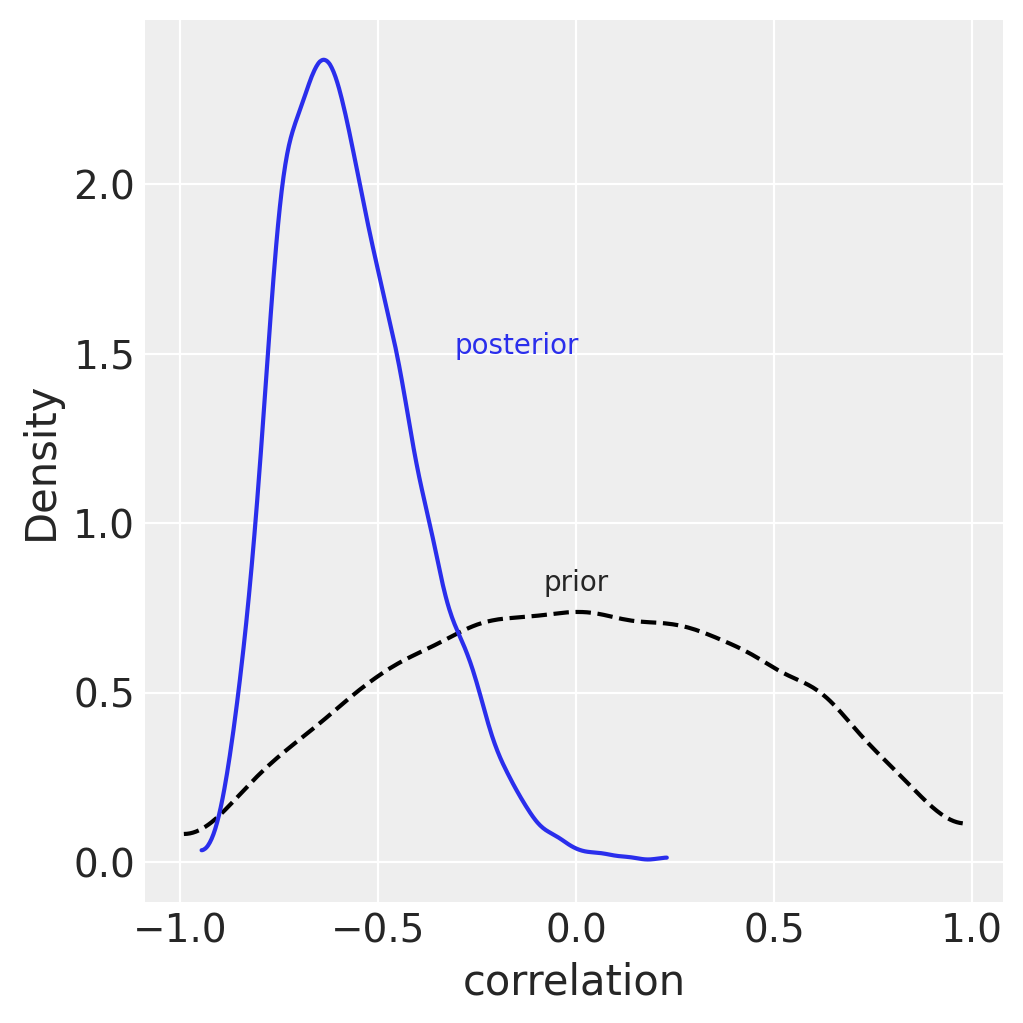

<IPython.core.display.Javascript object>

In [71]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
az.plot_kde(R, plot_kwargs={"color": "k", "linestyle": "--"})
ax.text(0, 0.8, "prior", horizontalalignment="center")

az.plot_kde(
    post["Rho"].sel(chol_cov_corr_dim_0=1, chol_cov_corr_dim_1=0),
    plot_kwargs={"color": "C0"},
)
ax.text(-0.15, 1.5, "posterior", color="C0", horizontalalignment="center")

ax.set_xlabel("correlation")
ax.set_ylabel("Density");

## Dyads book code

In [381]:
kl_dyads = df_kl.copy()
N = len(kl_dyads)
N_households = kl_dyads.hidB.max()
did = (kl_dyads.did - 1).values
hidA = (kl_dyads.hidA - 1).values
hidB = (kl_dyads.hidB - 1).values

<IPython.core.display.Javascript object>

In [374]:
did


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

<IPython.core.display.Javascript object>

In [375]:
with pm.Model() as m14_7:
    ## gr matrix of varying effects
    sd_dist = pm.Exponential.dist(1.0)
    chol_gr, _, _ = pm.LKJCholeskyCov("chol_gr", n=2, eta=4, sd_dist=sd_dist, compute_corr=True)
    gr = pm.MvNormal("gr", mu=0.0, chol=chol_gr, shape=(N_households, 2))

    ## dyad effects
    chol_dyad, _, _ = pm.LKJCholeskyCov("chol_dyad", n=2, eta=8, sd_dist=sd_dist, compute_corr=True)
    z = pm.Normal("z", 0.0, 1.0, shape=(2, N))
    d = pm.Deterministic("d", pm.math.dot(chol_dyad, z).T)

    # linear models
    a = pm.Normal("a", mu=0.0, sd=1.0)
    lambdaAB = pm.math.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[did, 0])
    lambdaBA = pm.math.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[did, 1])

    giftsAB = pm.Poisson("giftsAB", lambdaAB, observed=kl_dyads.giftsAB)
    giftsBA = pm.Poisson("giftsBA", lambdaBA, observed=kl_dyads.giftsBA)

    trace_14_7 = pm.sample(2000, tune=3000, random_seed=RANDOM_SEED)
    idata_14_7 = az.from_pymc3(
        trace_14_7,
        dims={"d": ["Dyad", "House"], "gr": ["Household", "Rate"]},
        coords={"Rate": ["giving", "receiving"]},
    )
post_14_7 = idata_14_7.posterior = idata_14_7.posterior.rename_vars(
    {
        "chol_gr_corr": "Rho_gr",
        "chol_gr_stds": "sigma_gr",
        "chol_dyad_corr": "Rho_d",
        "chol_dyad_stds": "sigma_d",
    }
)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, z, chol_dyad, gr, chol_gr]
INFO:pymc3:NUTS: [a, z, chol_dyad, gr, chol_gr]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 279 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 279 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [377]:
# az.summary(trace_14_7)

<IPython.core.display.Javascript object>

In [378]:
az.summary(idata_14_7, var_names=["Rho_gr", "sigma_gr"], round_to=2)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"Rho_gr[0,0]",1.00,0.00,1.00,1.00,0.0,0.0,8000.00,8000.00,8000.00,8000.00,NaN
"Rho_gr[0,1]",-0.42,0.20,-0.73,-0.12,0.0,0.0,2853.60,2780.63,2781.46,4239.92,1.0
"Rho_gr[1,0]",-0.42,0.20,-0.73,-0.12,0.0,0.0,2853.60,2780.63,2781.46,4239.92,1.0
"Rho_gr[1,1]",1.00,0.00,1.00,1.00,0.0,0.0,8000.00,8000.00,8318.25,8000.00,1.0
sigma_gr[0],0.83,0.14,0.62,1.04,0.0,0.0,5087.16,4986.74,5283.08,5190.87,1.0
sigma_gr[1],0.41,0.09,0.27,0.55,0.0,0.0,1905.32,1905.32,1825.35,2711.64,1.0


<IPython.core.display.Javascript object>

In [380]:
g = (post_14_7["a"] + post_14_7["gr"].sel(Rate="giving")).stack(sample=("chain", "draw"))
r = (post_14_7["a"] + post_14_7["gr"].sel(Rate="receiving")).stack(sample=("chain", "draw"))
Eg_mu = np.exp(g).mean(dim="sample")
Er_mu = np.exp(r).mean(dim="sample")

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Wed Jan 26 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

statsmodels: 0.12.2
scipy      : 1.6.0
pandas     : 1.2.1
arviz      : 0.11.1
daft       : 0.1.0
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
numpy      : 1.20.1
matplotlib : 3.3.4
pymc3      : 3.11.0
seaborn    : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>